In [84]:
#importamos las librerías generales a utilizar
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


#creamos función para abrir .txt
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data


### Inciso(a)

In [141]:

redes = {'Y2H': './data/yeast_Y2H.txt', 
         'Sistema Electrico': './data/power_enlaces.txt',
         'Papers': './data/netscience.gml',
         'Internet': './data/as-22july06.gml'
         }


def info_red(red):
    nombre, extension = os.path.splitext(red)
    if extension != '.txt':
        Red = nx.read_gml('./data/as-22july06.gml')
    else:
        lista_de_enlaces = abrir_txt(red)
        Red = nx.Graph()
        Red.add_edges_from(lista_de_enlaces)
    Grafo = Red
    Grados = Red.degree()
    return Grafo,Grados

def distribucion_grado_normal(lista_grados):
    
    hist,binedges = np.histogram(lista_grados,density=True,bins=max(lista_grados))
    bincenters = np.round(np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0))
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]
    
def cumulative_binning(lista_grados):
    lista_grados= np.flip(np.sort((lista_grados)))
    ranking = np.arange(1,len(lista_grados)+1)
    pk = ranking/len(ranking)                  
    return lista_grados,pk
    
     

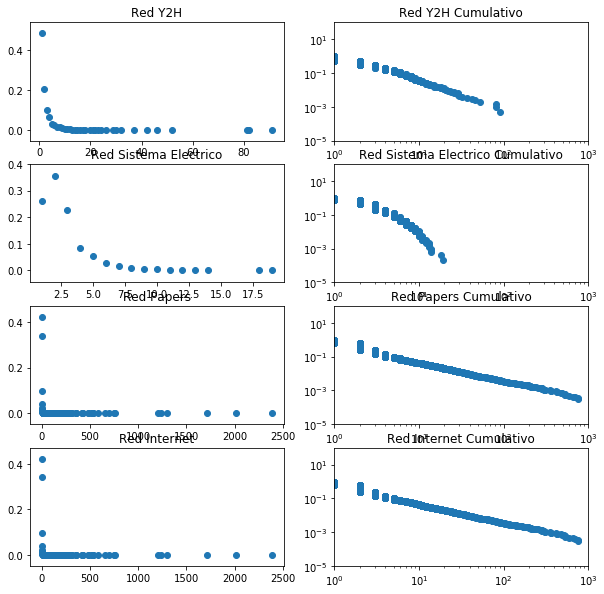

In [142]:
fig, axes = plt.subplots( nrows=4,ncols=2, figsize=(10, 10))

grados_dict = {}
for i, red in enumerate(redes.keys()):
    Grafo, Grados = info_red(redes[red])
    lista_grados= [val for (node, val) in Grados]
    grados_dict[red] = lista_grados

for i,red  in enumerate(redes.keys()):
    lista_grados = grados_dict[red]
    
    #plot distribucion regular
    x1,y1 = distribucion_grado_normal(lista_grados)
    axes[i,0].scatter(x1,y1)
    axes[i,0].set_title(f"Red {red}")
        
    #plot distribucion cumulativa
    x2,y2 = cumulative_binning(lista_grados)
    axes[i,1].scatter(x2,y2)
    axes[i,1].set_title(f"Red {red} Cumulativo")
    axes[i,1].set_yscale("log")
    axes[i,1].set_xscale("log")
    axes[i,1].set_xlim(10**0,10**3)
    axes[i,1].set_ylim(10**-5,10**2)
        



### Inciso(b)
Discuta cuál o cuáles casos se ajustan mejor a una ‘power law’, donde la probabilidad de
que un nodo tenga un dado grado k está dada por la ecuación: Pk = Ck−γ


### Inciso(c)
Diga si encuentra algún efecto de borde dado por el tamaño finito de las redes, y para cuáles
redes es más o menos apreciable

(Discutir con las chicas):
No se con cuanta formalidad tenemos que justificar a priori los efectos de borde. Lo que voy a hacer es redefinir pk para la  red que presenta mas efecto de borde (Sistema Electrico) y mostrar el regimen lineal a partir de la distribucion prima (pk').

Para una red con efectos de borde tenemos que:
$ p_{k} = a(k+k_{sat})^{-\gamma}e^{-\frac{k}{k_{cut}}}$.
multiplicando por $e^{\frac{k}{k_{cut}}}$ en cada lado definimos pk':
$p_{k}' = p_{k} \frac{k}{k_{cut}}= a(k+k_{sat})^{-\gamma}$


(0.01, 0.1)

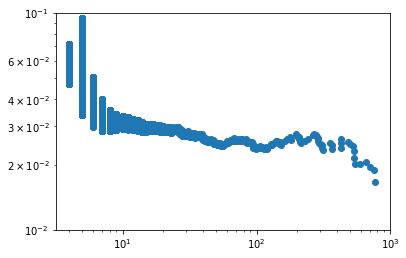

In [177]:
def pk_prima(lista_gardos,kcut):
    k,pk = cumulative_binning(lista_grados)
    return np.array(k) , np.array(pk)*np.array(k)/ kcut

ksat = 3
kcut = 14
k,pk_p =  pk_prima(grados_dict['Sistema Electrico'],kcut)
plt.figure()
plt.scatter(k + ksat,pk_p)
plt.yscale("log")
plt.xscale("log")
plt.xlim(10**0.5,10**3)
plt.ylim(10**-2,10**-1)
    
    

### Inciso(d)

Para estimar la cantidad de bins para el bineado logaritmico utilizaremos la regla de Scott$^{[1]}$:
(https://en.wikipedia.org/wiki/Histogram#Scott%27s_normal_reference_rule)

El razonamiento es el siguiente: 
Commo los datos estan bien aproximados por una distribucion logo-normal, si uso logbins mis datos van a estar distribuidos aprox normalmente. Asi que uso Scott's rule que minimiza el promedio 
From trying different bin sizes I know that my data is well approximated by a log normal distribution. Choosing log bins transforms my data into approximately normally distributed data. From the wiki article I take that Scott's rule minimizes the mean squared error of the density estimate.

[1] Scott, David W. (1979). “On optimal and data-based histograms”. Biometricka 66 (3): 605-610

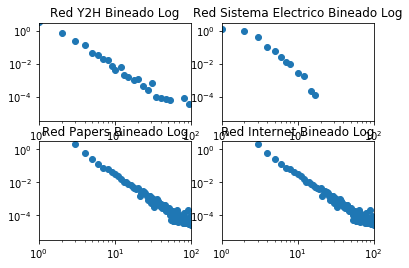

In [114]:
from astropy.stats import scott_bin_width

def log_binning(Grados):
    lista_grados= [val for (node, val) in Grados]
    
    #estimo los bins
    ancho_medio, binedges_medio = scott_bin_width(lista_grados,return_bins=True)
    num_bins = int(max(lista_grados)/ancho_medio)
    espaciado_log = np.logspace(0, 4, endpoint=True, base=10,num=num_bins)
    
    hist,binedges = np.histogram(lista_grados,espaciado_log,density=True)
    bincenters = np.round(np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0))
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]


for i, red in enumerate(redes.keys()):
#plot bineado logaritmico
    x,y = log_binning(redes[red])
    plt.subplot(221+i)
    plt.scatter(x,y)
    plt.title(f"Red {red} Bineado Log")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(10**0,10**2)
    plt.ylim(10**-5.5,10**0.5)

Funcionó demasiado mal esa forma de estimar los bins, discutir con las chicas.
Voy a utilizar la definición del bineado logarítmico para estimar la cantidad de bines donde:
    $b_{i} = b_{i-1} + 2^{i}$

91
8
19
6
2390
13
2390
13


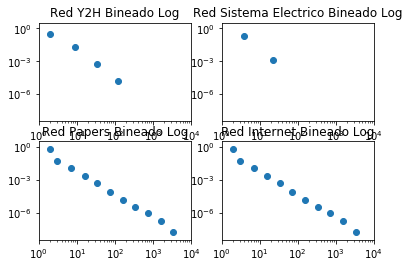

In [157]:

def log_binning_2(red):
    Grafo,Grados = info_red(red)
    lista_grados= [val for (node, val) in Grados]
    b = [0]
    i=0
    while b[-1] <= max(lista_grados):
        bi = b[-1] + 2**i
        b.append(bi)
        i += 1
        
    num_bins = len(b)
    espaciado_log = np.logspace(0, 4, endpoint=True, base=10,num=num_bins)
    
    hist,binedges = np.histogram(lista_grados,espaciado_log,density=True)
    bincenters = np.round(np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0))
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]

for i, red in enumerate(redes.keys()):
    #plot bineado logaritmico
    x,y = log_binning_2(redes[red])
    plt.subplot(221+i)
    plt.scatter(x,y)
    plt.title(f"Red {red} Bineado Log")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(10**0,10**4)
    plt.ylim(10**-8.5,10**0.5)


Ajusto para ver si se cumplen las leyes de potencia para cada red:
$p(k) = Ck^{-\gamma}$.
Con el bineado logaritmico me queda:
$C = (\gamma - 1) K_{min}^{(\gamma-1)}$.
Donde $K_min$ es el k que maximiza la probabilidad L:
$ L(k|\gamma) = \prod_{i=1}^{N} p(k) = \prod_{i=1}^{N} \frac{\gamma -1}{K_{min}} (\frac{k_i}{K_{min}})^{-\gamma} $
yada yada

Tengo que corregir esto porque no funciona muy bien para las power laws que tienen cola pesada. (Inciso c)

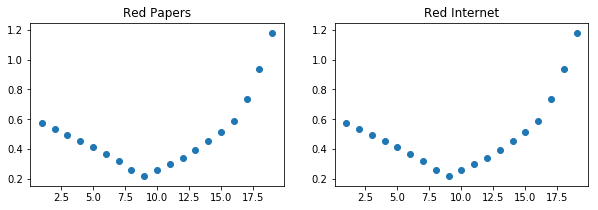

In [178]:


def gamma(N,k,kmin):
    return 1 + N * 1/(np.sum(np.log(k/(kmin-0.5))))

def L_real(pk):
    lista_L = []
    for i in range(len(pk)):
        L_i = np.prod(pk[0:i+1])
        lista_L.append(L_i)
    return np.array(lista_L)

def L(N,k,kmin):
    lista_L = []
    for i in k:
        L_i = np.prod(((gamma(N,k,kmin)-1)/kmin)*((i/kmin)**(-gamma(N,k,kmin))))
        lista_L.append(L_i)
    return np.array(lista_L)

#esta funcion es para probar distintos kmin y ver cual kmin maximiza la prob
def D_max(N,k,kmin):
    L_aproximacion = L(N,k,kmin)
    L_datos = L_real(pk)
    return np.max(np.absolute(L_datos - L_aproximacion))
    
#aca graafico ladiferencia de los dos plots en funcion de kmin
redes_cola_pesada = {'Papers': './data/netscience.gml',
         'Internet': './data/as-22july06.gml'}

fig, axes = plt.subplots( nrows=1,ncols=2, figsize=(10,3))

for i,red in enumerate(redes_cola_pesada.keys()):
    k,pk = log_binning(redes_cola_pesada[red])
    N = len(k)
    Ds = []
    for j in range(1,20):
        D = D_max(N,k,j)
        Ds.append(D)
    axes[i].scatter(range(1,20),Ds)
    axes[i].set_title(f"Red {red}")

    